In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE

In [184]:
train = pd.read_csv('train.csv')
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [185]:
train.shape

(230130, 6)

In [186]:
train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [187]:
train['num_sold'] = train['num_sold'].fillna(train['num_sold'].median())

In [188]:
train.describe()

,id,num_sold
count,230130.000000,230130.000000
mean,115064.500000,746.840529
std,66432.953062,677.328201
min,0.000000,5.000000
25%,57532.250000,230.000000
50%,115064.500000,605.000000
75%,172596.750000,1084.000000
max,230129.000000,5939.000000


In [189]:
train.duplicated().sum()

0

<Axes: >

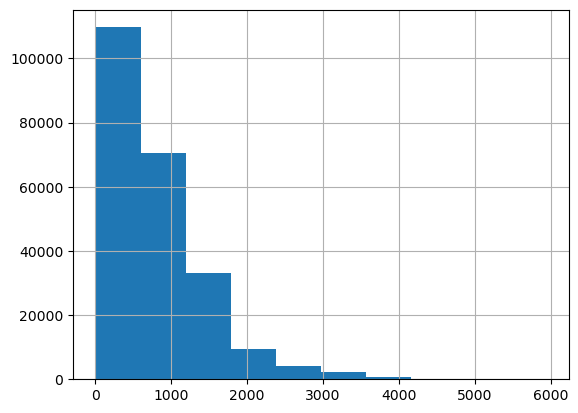

In [190]:
train['num_sold'].hist()

In [191]:
def replace_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    median_value = df[column].median()
    df[column] = np.where((df[column]<lower)|(df[column]>upper), median_value, df[column])
    return df

In [192]:
numerical_columns = train.select_dtypes(exclude='object').drop( 'id', axis = 1)
numerical_columns.columns

Index(['num_sold'], dtype='object')

In [193]:
for col in numerical_columns.columns:
    concat_df = replace_outliers(concat_df, col)

In [194]:
test = pd.read_csv('test.csv')
test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [195]:
test.shape

(98550, 5)

In [196]:
test.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [197]:
test.describe()

,id
count,98550.000000
mean,279404.500000
std,28449.078852
min,230130.000000
25%,254767.250000
50%,279404.500000
75%,304041.750000
max,328679.000000


In [198]:
concat_df = pd.concat([train, test], axis = 0)
concat_df.shape

(328680, 6)

In [199]:
categorical_columns = concat_df.select_dtypes(include='object').drop(['date'], axis = 1)
categorical_columns.columns


Index(['country', 'store', 'product'], dtype='object')

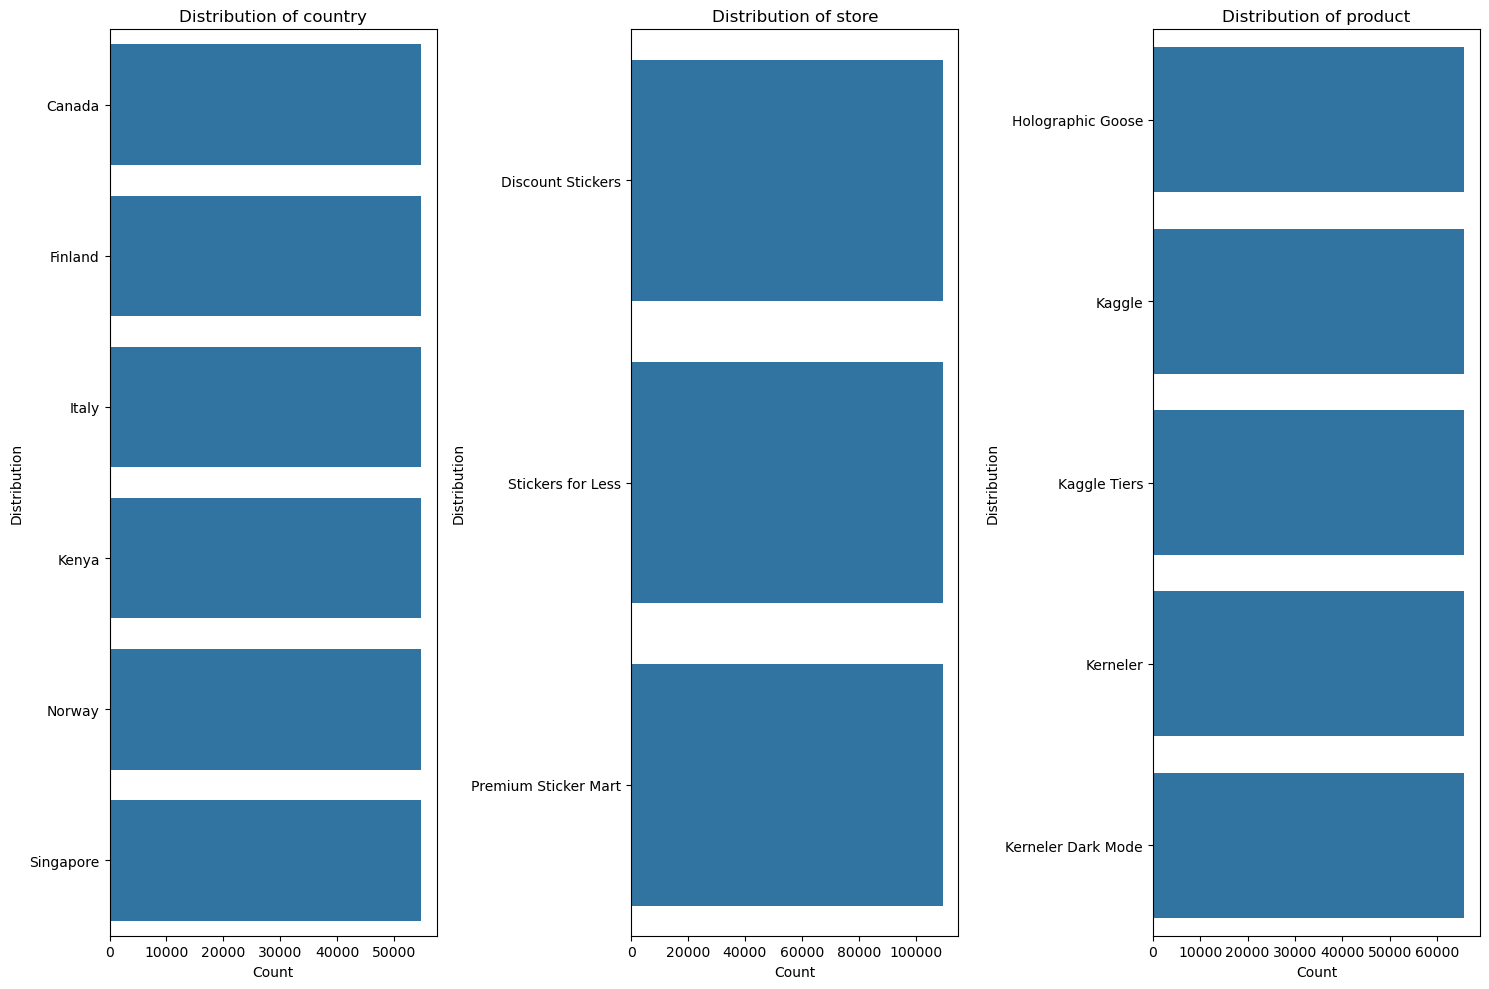

In [200]:
fig, axes = plt.subplots(1, 3, figsize= (15,10))
axes = axes.flatten()

for i, col in enumerate(categorical_columns.columns):
    sns.countplot(y=col, data=concat_df, ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Distribution')

plt.tight_layout()
plt.show()

In [201]:
concat_df.date = pd.to_datetime(concat_df.date)
concat_df['year'] = concat_df.date.dt.year
concat_df['month'] = concat_df.date.dt.month
concat_df['day'] = concat_df.date.dt.day

In [202]:
for col in ['month', 'day']:
    max_val = 12 if col == 'month' else 31
    concat_df[f'{col}_sin'] = np.sin(2 * np.pi * concat_df[col]/max_val)
    concat_df[f'{col}_cos'] = np.cos(2 * np.pi * concat_df[col]/max_val)

In [203]:
concat_df['day_of_week'] = concat_df['date'].dt.dayofweek  
concat_df['is_weekend'] = (concat_df['date'].dt.weekday >= 5).astype(np.uint8)
concat_df['quarter'] = concat_df['date'].dt.quarter 

In [204]:
concat_df = concat_df.drop(['date', 'id'], axis=1)
concat_df = pd.get_dummies(concat_df)
concat_df

,num_sold,year,month,day,month_sin,month_cos,day_sin,day_cos,day_of_week,is_weekend,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,605.0,2010,1,1,5.000000e-01,0.866025,2.012985e-01,0.97953,4,0,...,False,False,True,False,False,True,False,False,False,False
1,973.0,2010,1,1,5.000000e-01,0.866025,2.012985e-01,0.97953,4,0,...,False,False,True,False,False,False,True,False,False,False
2,906.0,2010,1,1,5.000000e-01,0.866025,2.012985e-01,0.97953,4,0,...,False,False,True,False,False,False,False,True,False,False
3,423.0,2010,1,1,5.000000e-01,0.866025,2.012985e-01,0.97953,4,0,...,False,False,True,False,False,False,False,False,True,False
4,491.0,2010,1,1,5.000000e-01,0.866025,2.012985e-01,0.97953,4,0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,NaN,2019,12,31,-2.449294e-16,1.000000,-2.449294e-16,1.00000,1,0,...,False,True,False,True,False,True,False,False,False,False
98546,NaN,2019,12,31,-2.449294e-16,1.000000,-2.449294e-16,1.00000,1,0,...,False,True,False,True,False,False,True,False,False,False
98547,NaN,2019,12,31,-2.449294e-16,1.000000,-2.449294e-16,1.00000,1,0,...,False,True,False,True,False,False,False,True,False,False
98548,NaN,2019,12,31,-2.449294e-16,1.000000,-2.449294e-16,1.00000,1,0,...,False,True,False,True,False,False,False,False,True,False


In [205]:
concat_df.shape

(328680, 25)

In [230]:
newtrain = concat_df.iloc[0:230130, :]
newtest = concat_df.iloc[230130:, :].drop('num_sold', axis = 1)

In [232]:
newtrain.head()

,num_sold,year,month,day,month_sin,month_cos,day_sin,day_cos,day_of_week,is_weekend,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,605.0,2010,1,1,0.5,0.866025,0.201299,0.97953,4,0,...,False,False,True,False,False,True,False,False,False,False
1,973.0,2010,1,1,0.5,0.866025,0.201299,0.97953,4,0,...,False,False,True,False,False,False,True,False,False,False
2,906.0,2010,1,1,0.5,0.866025,0.201299,0.97953,4,0,...,False,False,True,False,False,False,False,True,False,False
3,423.0,2010,1,1,0.5,0.866025,0.201299,0.97953,4,0,...,False,False,True,False,False,False,False,False,True,False
4,491.0,2010,1,1,0.5,0.866025,0.201299,0.97953,4,0,...,False,False,True,False,False,False,False,False,False,True


In [234]:
newtest.head()

,year,month,day,month_sin,month_cos,day_sin,day_cos,day_of_week,is_weekend,quarter,...,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,2017,1,1,0.5,0.866025,0.201299,0.97953,6,1,1,...,False,False,True,False,False,True,False,False,False,False
1,2017,1,1,0.5,0.866025,0.201299,0.97953,6,1,1,...,False,False,True,False,False,False,True,False,False,False
2,2017,1,1,0.5,0.866025,0.201299,0.97953,6,1,1,...,False,False,True,False,False,False,False,True,False,False
3,2017,1,1,0.5,0.866025,0.201299,0.97953,6,1,1,...,False,False,True,False,False,False,False,False,True,False
4,2017,1,1,0.5,0.866025,0.201299,0.97953,6,1,1,...,False,False,True,False,False,False,False,False,False,True


In [236]:
newtrain.shape

(230130, 25)

In [238]:
newtest.shape

(98550, 24)

In [240]:
x = newtrain.drop('num_sold', axis = 1)
y = newtrain['num_sold']

In [242]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [246]:
models = {'Linear Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(),
         'XGB': XGBRegressor()}


In [250]:
def evaluate_models(x_train,x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        predictions = model.fit(x_train, y_train).predict(x_test)
        accuracy = mean_absolute_percentage_error(y_test, predictions)
        results[name] = accuracy
    return results


In [252]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 24
[LightGBM] [Info] Start training from score 746.839645


In [253]:
best_model_name = min(results, key = results.get)
best_model = models[best_model_name]

In [254]:
print(f"best model is {best_model_name} with mape {results[best_model_name]}")

best model is Extra Tree with mape 0.24713625283144033


In [255]:
x_train = newtrain.drop('num_sold', axis = 1)
y_train = newtrain['num_sold']
x_test = newtest
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [256]:
solution = pd.DataFrame({'id':test['id'], 'num_sold': y_pred})
solution.head()

,id,num_sold
0,230130,605.00
1,230131,728.64
2,230132,677.09
3,230133,379.77
4,230134,404.54


In [257]:
solution.to_csv('Solution.csv', index = False)